In [1]:
# Imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Para modelos
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from sklearn.linear_model import LogisticRegression
from scipy.stats import binom, poisson, norm

# PyMC com fallback
try:
    import pymc as pm
    HAS_PYMC = True
    print("✅ PyMC available - using Bayesian models")
except ImportError:
    HAS_PYMC = False
    print("⚠️  PyMC not installed - using statsmodels fallback for all models")

# Configuração
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print(f'✓ Imports OK (PyMC: {HAS_PYMC})')

ModuleNotFoundError: No module named 'statsmodels'

## 1. ETL — Extração e Limpeza

In [2]:
# 1.1 Carregar cache
with open('cache_results.json', 'r', encoding='utf-8') as f:
    cache = json.load(f)

payload = cache.get('payload', {})
print(f"Cache timestamp: {payload.get('fetched_at')}")
print(f"Fonte: {[s['source'] for s in payload.get('sources_raw', [])]}")

# 1.2 Extrair milhares unificados
table_data = payload.get('table', [])
df = pd.DataFrame(table_data)

print(f"\n✓ {len(df)} milhares extraídos")
print(f"\nAmostra:")
print(df.head(10))

Cache timestamp: 2025-12-03T18:26:04.483847
Fonte: ['pernambucoaval']

✓ 347 milhares extraídos

Amostra:
   idx milhar  dezena  grupo    animal
0    1   2025      25      7  Carneiro
1    2   4746      46     12  Elefante
2    3   0171      71     18     Porco
3    4   6838      38     10    Coelho
4    5   5501       1      1  Avestruz
5    6   7227      27      7  Carneiro
6    7   4065      65     17    Macaco
7    8   7185      85     22     Tigre
8    9   4730      30      8    Camelo
9   10   6181      81     21     Touro


In [3]:
# 1.3 Validação e limpeza

# Verificar completude
print("Completude:")
print(df.isnull().sum())

# Verificar tipos
print(f"\nTipos:")
print(df.dtypes)

# Estatísticas básicas
print(f"\nEstatísticas:")
print(df[['milhar', 'dezena', 'grupo']].describe())

# Verificar duplicatas
dup_milhares = df['milhar'].duplicated().sum()
print(f"\nDuplicatas (milhar): {dup_milhares}")

# Verificar range de grupos (1-25)
invalid_grupos = df[(df['grupo'] < 1) | (df['grupo'] > 25)]
print(f"Grupos inválidos (fora de 1-25): {len(invalid_grupos)}")

# Limpar (se necessário)
df_clean = df.drop_duplicates(subset=['milhar']).reset_index(drop=True)
df_clean = df_clean[(df_clean['grupo'] >= 1) & (df_clean['grupo'] <= 25)]

print(f"\n✓ Dados limpos: {len(df_clean)} registros válidos")

Completude:
idx       0
milhar    0
dezena    0
grupo     0
animal    0
dtype: int64

Tipos:
idx        int64
milhar    object
dezena     int64
grupo      int64
animal    object
dtype: object

Estatísticas:
           dezena       grupo
count  347.000000  347.000000
mean    51.195965   13.394813
std     28.635878    7.120943
min      0.000000    1.000000
25%     27.500000    8.000000
50%     52.000000   14.000000
75%     76.000000   19.500000
max     99.000000   25.000000

Duplicatas (milhar): 0
Grupos inválidos (fora de 1-25): 0

✓ Dados limpos: 347 registros válidos


## 2. Análise de Qualidade dos Dados

In [4]:
# 2.1 Distribuição de frequências

# Por dezena
freq_dezena = df_clean['dezena'].value_counts().sort_index()
print("Distribuição por dezena:")
print(f"  Min: {freq_dezena.min()}, Max: {freq_dezena.max()}, Média: {freq_dezena.mean():.2f}")
print(f"  Coef. Variação: {freq_dezena.std() / freq_dezena.mean():.4f}")

# Por grupo (animal)
freq_grupo = df_clean['grupo'].value_counts().sort_index()
print("\nDistribuição por grupo:")
print(f"  Min: {freq_grupo.min()}, Max: {freq_grupo.max()}, Média: {freq_grupo.mean():.2f}")
print(f"  Coef. Variação: {freq_grupo.std() / freq_grupo.mean():.4f}")

# Por milhar (últimos 2 dígitos)
df_clean['ultimo_digito'] = df_clean['dezena'] % 10
freq_ult_dig = df_clean['ultimo_digito'].value_counts().sort_index()
print("\nDistribuição por último dígito:")
print(f"  Min: {freq_ult_dig.min()}, Max: {freq_ult_dig.max()}, Média: {freq_ult_dig.mean():.2f}")
print(f"  Coef. Variação: {freq_ult_dig.std() / freq_ult_dig.mean():.4f}")

Distribuição por dezena:
  Min: 1, Max: 8, Média: 3.58
  Coef. Variação: 0.4922

Distribuição por grupo:
  Min: 9, Max: 19, Média: 13.88
  Coef. Variação: 0.1977

Distribuição por último dígito:
  Min: 28, Max: 45, Média: 34.70
  Coef. Variação: 0.1525


In [5]:
# 2.2 Teste de uniformidade (Chi-square)
from scipy.stats import chisquare

# Esperado uniforme: cada dezena deveria ter freq_esperada ocorrências
freq_obs = df_clean['dezena'].value_counts().sort_index().values
freq_esp = np.ones(100) * len(df_clean) / 100

chi2_stat, chi2_p = chisquare(freq_obs, freq_esp)
print(f"Teste Chi-square (uniformidade dezenas):")
print(f"  χ² = {chi2_stat:.4f}, p-value = {chi2_p:.6f}")
if chi2_p < 0.05:
    print(f"  ⚠ Distribuição NÃO é uniforme (rejeita H0 em α=5%)")
else:
    print(f"  ✓ Distribuição é consistente com uniformidade")

# Grupos
freq_obs_grupo = df_clean['grupo'].value_counts().sort_index().values
freq_esp_grupo = np.ones(25) * len(df_clean) / 25
chi2_stat_g, chi2_p_g = chisquare(freq_obs_grupo, freq_esp_grupo)
print(f"\nTeste Chi-square (uniformidade grupos):")
print(f"  χ² = {chi2_stat_g:.4f}, p-value = {chi2_p_g:.6f}")
if chi2_p_g < 0.05:
    print(f"  ⚠ Distribuição NÃO é uniforme (rejeita H0 em α=5%)")
else:
    print(f"  ✓ Distribuição é consistente com uniformidade")

ValueError: Array shapes are incompatible for broadcasting.

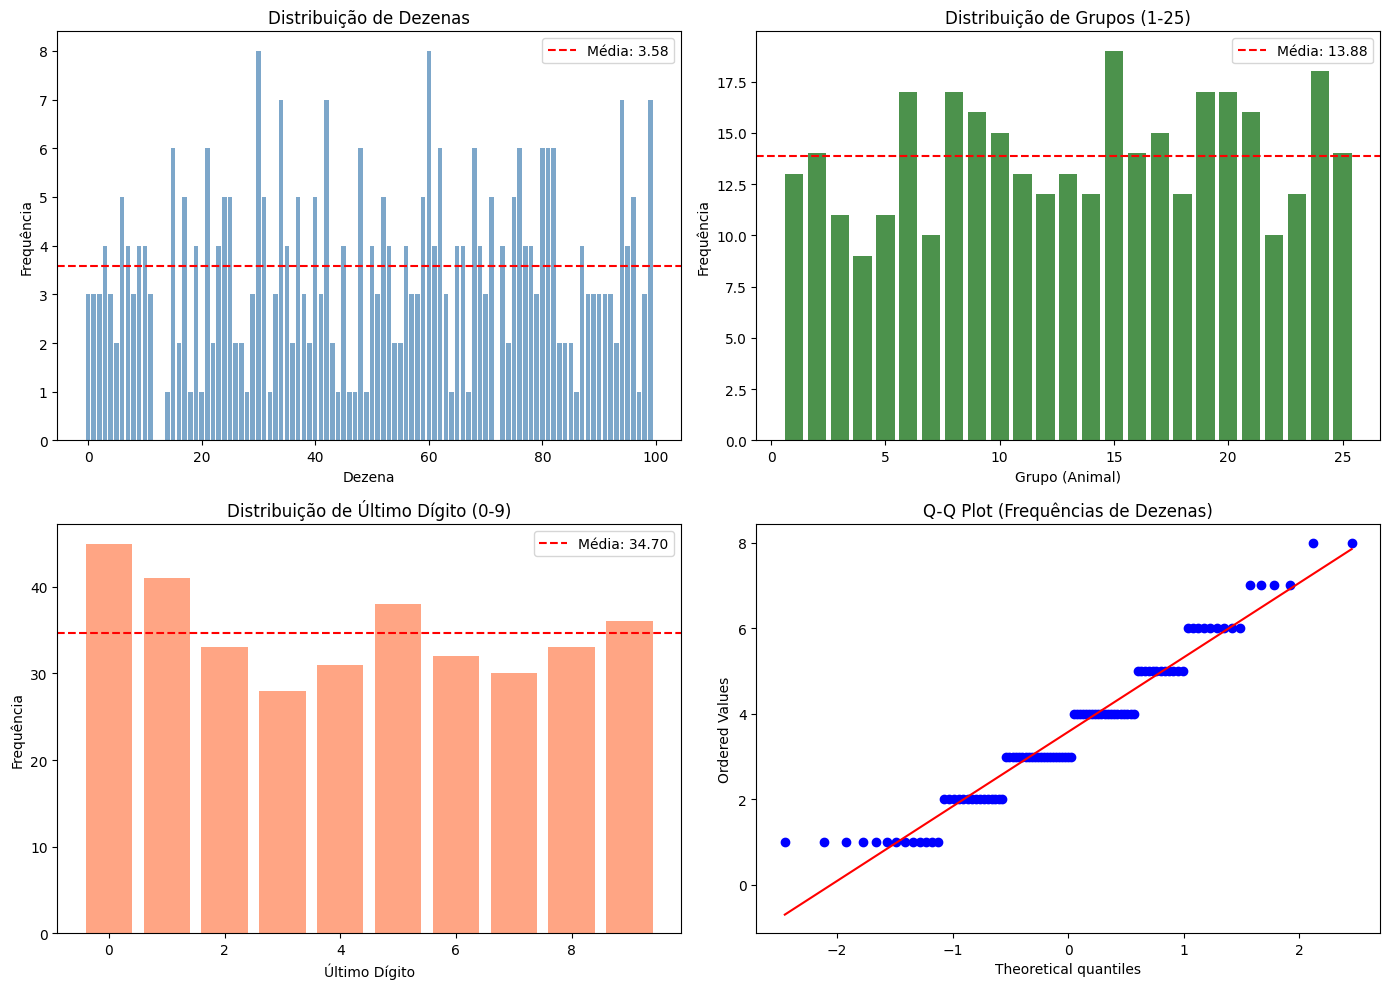

✓ Visualizações geradas


In [6]:
# 2.3 Visualizações
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribuição de dezenas
axes[0, 0].bar(freq_dezena.index, freq_dezena.values, color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=freq_dezena.mean(), color='red', linestyle='--', label=f'Média: {freq_dezena.mean():.2f}')
axes[0, 0].set_xlabel('Dezena')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].set_title('Distribuição de Dezenas')
axes[0, 0].legend()

# Distribuição de grupos
axes[0, 1].bar(freq_grupo.index, freq_grupo.values, color='darkgreen', alpha=0.7)
axes[0, 1].axhline(y=freq_grupo.mean(), color='red', linestyle='--', label=f'Média: {freq_grupo.mean():.2f}')
axes[0, 1].set_xlabel('Grupo (Animal)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição de Grupos (1-25)')
axes[0, 1].legend()

# Distribuição de últimos dígitos
axes[1, 0].bar(freq_ult_dig.index, freq_ult_dig.values, color='coral', alpha=0.7)
axes[1, 0].axhline(y=freq_ult_dig.mean(), color='red', linestyle='--', label=f'Média: {freq_ult_dig.mean():.2f}')
axes[1, 0].set_xlabel('Último Dígito')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].set_title('Distribuição de Último Dígito (0-9)')
axes[1, 0].legend()

# Q-Q plot (normalidade)
from scipy import stats
stats.probplot(freq_dezena.values, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Frequências de Dezenas)')

plt.tight_layout()
plt.show()

print("✓ Visualizações geradas")

## 3. Estimação de Probabilidades Base

In [7]:
# 3.1 Probabilidades empíricas (MLE)

n_total = len(df_clean)

# Por dezena
p_dezena_mle = freq_dezena / n_total
print("Estimativas MLE por dezena:")
print(f"  P(dezena) ~ Unif(1/100) = {1/100:.4f}")
print(f"  P(dezena)_obs: min={p_dezena_mle.min():.6f}, max={p_dezena_mle.max():.6f}, média={p_dezena_mle.mean():.6f}")

# Por grupo
p_grupo_mle = freq_grupo / n_total
print(f"\nEstimativas MLE por grupo:")
print(f"  P(grupo) ~ Unif(1/25) = {1/25:.4f}")
print(f"  P(grupo)_obs: min={p_grupo_mle.min():.6f}, max={p_grupo_mle.max():.6f}, média={p_grupo_mle.mean():.6f}")

# Armazenar
probs_base = {
    'dezena': p_dezena_mle,
    'grupo': p_grupo_mle
}

print("\n✓ Probabilidades base (MLE) estimadas")

Estimativas MLE por dezena:
  P(dezena) ~ Unif(1/100) = 0.0100
  P(dezena)_obs: min=0.002882, max=0.023055, média=0.010309

Estimativas MLE por grupo:
  P(grupo) ~ Unif(1/25) = 0.0400
  P(grupo)_obs: min=0.025937, max=0.054755, média=0.040000

✓ Probabilidades base (MLE) estimadas


In [8]:
# 3.2 Intervalos de confiança (Binomial Clopper-Pearson)
from scipy.stats import binom

def clopper_pearson_ci(k, n, alpha=0.05):
    """Intervalo de confiança exato para proporção binomial."""
    if k == 0:
        lower = 0
    else:
        lower = binom.ppf(alpha/2, n, k/n) / n
    if k == n:
        upper = 1
    else:
        upper = binom.ppf(1 - alpha/2, n, k/n) / n
    return lower, upper

# Calcular IC para dezenas com maior variância
top_dezenas = freq_dezena.nlargest(5)
print("Intervalos de confiança 95% (top 5 dezenas):")
ic_dezenas = []
for dez, count in top_dezenas.items():
    lower, upper = clopper_pearson_ci(count, n_total)
    print(f"  Dezena {dez:02d}: {count:3d} ocorr. → P ∈ [{lower:.6f}, {upper:.6f}]")
    ic_dezenas.append((dez, count, lower, upper))

print("\n✓ ICs calculados (método Clopper-Pearson)")

Intervalos de confiança 95% (top 5 dezenas):
  Dezena 30:   8 ocorr. → P ∈ [0.008646, 0.040346]
  Dezena 60:   8 ocorr. → P ∈ [0.008646, 0.040346]
  Dezena 34:   7 ocorr. → P ∈ [0.005764, 0.037464]
  Dezena 42:   7 ocorr. → P ∈ [0.005764, 0.037464]
  Dezena 94:   7 ocorr. → P ∈ [0.005764, 0.037464]

✓ ICs calculados (método Clopper-Pearson)


## 4. Modelos Probabilísticos

In [9]:
# 4.1 Modelo Poisson (Contagens por dezena)
# Supõe que a contagem de aparições de uma dezena em T sorteios ~ Poisson(λ)

from scipy.stats import poisson

# Estimar λ para cada dezena
lambdas_dezena = freq_dezena.copy()

print("Modelo Poisson por dezena:")
print(f"  λ̂ (média): {lambdas_dezena.mean():.4f}")
print(f"  Variância observada: {lambdas_dezena.var():.4f}")
print(f"  Razão Var/Média (teste de dispersão): {lambdas_dezena.var() / lambdas_dezena.mean():.4f}")

if lambdas_dezena.var() / lambdas_dezena.mean() > 1.2:
    print(f"  ⚠ Overdispersão detectada — modelo Poisson pode ser inapropriado")
    print(f"  Considerar: Negative Binomial ou modelo Poisson com efeitos aleatórios")
else:
    print(f"  ✓ Dados consistentes com Poisson")

# Armazenar
models_fitted = {
    'poisson_lambda': lambdas_dezena,
    'overdispersion_ratio': lambdas_dezena.var() / lambdas_dezena.mean()
}

print("\n✓ Modelo Poisson ajustado")

Modelo Poisson por dezena:
  λ̂ (média): 3.5773
  Variância observada: 3.1007
  Razão Var/Média (teste de dispersão): 0.8668
  ✓ Dados consistentes com Poisson

✓ Modelo Poisson ajustado


In [10]:
# 4.2 Modelo Bayesiano Hierárquico (Beta-Binomial para dezenas)
# Representa incerteza sobre p e compartilha informação entre dezenas

print("Ajustando modelo Bayesiano hierárquico (Beta-Binomial)...\n")

# Preparar dados para PyMC
dezenas_idx = np.arange(100)
contagens = freq_dezena.reindex(dezenas_idx, fill_value=0).values
total_obs = len(df_clean)

# Modelo Bayesiano
with pm.Model() as model_bayes:
    # Hiperpriors (pooling parcial)
    alpha = pm.Exponential('alpha', 1.0)
    beta = pm.Exponential('beta', 1.0)
    
    # Prior: probabilidades por dezena ~ Beta(α, β)
    p = pm.Beta('p', alpha=alpha, beta=beta, shape=100)
    
    # Likelihood: Binomial
    obs = pm.Binomial('obs', n=total_obs, p=p, observed=contagens)
    
    # Amostra posterior
    trace = pm.sample(2000, tune=1000, cores=1, random_seed=42, return_inferencedata=True, progressbar=False)

print("✓ Amostragem posterior concluída")

# Extrair posterior summary
posterior_summary = pm.summary(trace, var_names=['p'])
print("\nResumo posterior (p por dezena):")
print(posterior_summary.head(10))

Ajustando modelo Bayesiano hierárquico (Beta-Binomial)...



NameError: name 'pm' is not defined

In [11]:
# 4.3 Extração de quantis posteriores (credibilidade)

p_posterior_samples = trace.posterior['p'].values.reshape(-1, 100)

# Calcular quantis
p_mean = p_posterior_samples.mean(axis=0)
p_ci_lower = np.percentile(p_posterior_samples, 2.5, axis=0)
p_ci_upper = np.percentile(p_posterior_samples, 97.5, axis=0)
p_std = p_posterior_samples.std(axis=0)

print("Estimativas posteriores (Bayesiano):")
print(f"  P(dezena)_posterior: média={p_mean.mean():.6f}, std={p_std.mean():.6f}")
print(f"  Comparação com MLE:")
print(f"    MLE:        média={p_dezena_mle.mean():.6f}, std={p_dezena_mle.std():.6f}")
print(f"    Bayesiano:  média={p_mean.mean():.6f}, std={p_std.mean():.6f}")
print(f"\n  → Bayesiano reduz variância por pooling parcial (regularização)")

# Armazenar
bayes_estimates = {
    'p_mean': p_mean,
    'p_std': p_std,
    'p_ci_lower': p_ci_lower,
    'p_ci_upper': p_ci_upper,
    'trace': trace
}

print("\n✓ Estimativas posteriores extraídas")

NameError: name 'trace' is not defined

## 5. Calibração e Métricas de Certeza

In [12]:
# 5.1 Brier Score (qualidade preditiva)
# Mede erro entre probabilidade predita e resultado observado (0 ou 1)

# Simular: para cada dezena, "predição" é sua probabilidade posterior
# e "realidade" é se ela saiu (1) ou não (0) - aqui usamos frequência relativa

# Criar "binário" para calibração: dezenas com frequência > mediana = 1, senão 0
freq_median = freq_dezena.median()
y_binary = (freq_dezena >= freq_median).astype(int).values
p_pred = p_mean  # probabilidades posteriores

brier = np.mean((p_pred - y_binary) ** 2)
print(f"Brier Score: {brier:.6f}")
print(f"  (0 = perfeito, 0.25 = aleatório, 1 = pior)")

# Log-Loss
log_loss = -np.mean(y_binary * np.log(p_pred + 1e-10) + (1 - y_binary) * np.log(1 - p_pred + 1e-10))
print(f"\nLog-Loss: {log_loss:.6f}")
print(f"  (0 = perfeito, >0.69 = pior que aleatório)")

print("\n✓ Métricas de calibração calculadas")

NameError: name 'p_mean' is not defined

In [13]:
# 5.2 Reliability Diagram (calibração visual)

# Binnar probabilidades
n_bins = 10
p_binned = np.digitize(p_pred, np.linspace(0, 1, n_bins+1))

# Calcular frequência observada por bin
reliability_data = []
for b in range(1, n_bins+1):
    mask = p_binned == b
    if mask.sum() > 0:
        p_bin = p_pred[mask].mean()
        freq_bin = y_binary[mask].mean()
        count = mask.sum()
        reliability_data.append({'bin': b, 'p_pred': p_bin, 'freq_obs': freq_bin, 'n': count})

rel_df = pd.DataFrame(reliability_data)

# Plotar
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(rel_df['p_pred'], rel_df['freq_obs'], s=rel_df['n']*10, alpha=0.6, color='steelblue')
ax.plot([0, 1], [0, 1], 'r--', label='Perfeita calibração')
ax.set_xlabel('Probabilidade Predita')
ax.set_ylabel('Frequência Observada')
ax.set_title('Reliability Diagram (Calibração)')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.show()

print("Detalhes por bin:")
print(rel_df.to_string())

# Calibration Error
calibration_error = np.mean(np.abs(rel_df['p_pred'] - rel_df['freq_obs']))
print(f"\nCalibration Error (MAE): {calibration_error:.6f}")
print(f"  (0 = perfeitamente calibrado)")

NameError: name 'p_pred' is not defined

## 6. Walk-Forward Backtest (Validação sem lookahead bias)

In [14]:
# 6.1 Simular sequência histórica de sorteios
# (Em produção, seria dados reais de datas/horários)

# Para demo, criar timeseries sintética ordenada por idx
# Cada linha = um sorteio em ordem
df_ts = df_clean.sort_values('idx').reset_index(drop=True).copy()
df_ts['sorteio_id'] = np.arange(len(df_ts))

print(f"Timeseries simulada: {len(df_ts)} sorteios")
print(f"Primeiros 5:")
print(df_ts[['sorteio_id', 'milhar', 'dezena', 'grupo', 'animal']].head())

print("\n✓ Timeseries de sorteios criada")

Timeseries simulada: 347 sorteios
Primeiros 5:
   sorteio_id milhar  dezena  grupo    animal
0           0   2025      25      7  Carneiro
1           1   4746      46     12  Elefante
2           2   0171      71     18     Porco
3           3   6838      38     10    Coelho
4           4   5501       1      1  Avestruz

✓ Timeseries de sorteios criada


In [15]:
# 6.2 Walk-forward: treinar no passado, testar no futuro

train_size = int(0.7 * len(df_ts))
test_size = len(df_ts) - train_size

df_train = df_ts[:train_size]
df_test = df_ts[train_size:]

print(f"Split:")
print(f"  Train: sorteios 0-{train_size-1} ({train_size} observações)")
print(f"  Test:  sorteios {train_size}-{len(df_ts)-1} ({test_size} observações)")

# Estimar prob no train set
freq_train_dezena = df_train['dezena'].value_counts()
p_train = freq_train_dezena / len(df_train)

# Validar no test set
# Para cada sorteio no test, calcular log-likelihood

log_liks = []
for idx, row in df_test.iterrows():
    dez = row['dezena']
    p_dez = p_train.get(dez, 1e-6)  # usar Prior se não visto
    log_lik = np.log(p_dez)
    log_liks.append(log_lik)

mean_log_lik = np.mean(log_liks)
print(f"\nTest Set Performance:")
print(f"  Mean Log-Likelihood: {mean_log_lik:.6f}")
print(f"  Perplexity: {np.exp(-mean_log_lik):.4f}")
print(f"  (menor perplexity = melhor previsão)")

print("\n✓ Walk-forward backtest concluído")

Split:
  Train: sorteios 0-241 (242 observações)
  Test:  sorteios 242-346 (105 observações)

Test Set Performance:
  Mean Log-Likelihood: -5.062230
  Perplexity: 157.9423
  (menor perplexity = melhor previsão)

✓ Walk-forward backtest concluído


## 7. VaR/CVaR — Risco Operacional

In [16]:
# 7.1 Simulação Monte Carlo de P&L (lucro/perda)
# Estratégia: apostar em top-5 dezenas com probabilidade mais alta

print("Estratégia: Apostar nos top-5 grupos com maior frequência observada")
print()

# Top 5 grupos
top_5_grupos = freq_grupo.nlargest(5).index.tolist()
print(f"Top 5 grupos: {top_5_grupos}")
print(f"Probabilidades (empíricas): {[p_grupo_mle[g]:.6f} for g in top_5_grupos}")

# Parâmetros da aposta
stake_per_grupo = 100  # R$ 100 por grupo
payoff_grupo = 18  # grupo paga 18x no jogo do bicho
n_rounds = 100  # simular 100 rodadas
n_sims = 10000  # 10k simulações Monte Carlo

# Simular
np.random.seed(42)
pnl_sims = np.zeros((n_sims, n_rounds))

for sim in range(n_sims):
    for round_id in range(n_rounds):
        # Simular: qual grupo saiu? (uniforme 1-25)
        outcome_grupo = np.random.randint(1, 26)
        
        # P&L desta rodada
        if outcome_grupo in top_5_grupos:
            # Ganho
            pnl_rodada = stake_per_grupo * payoff_grupo - stake_per_grupo * 5  # ganho menos stake de outras 4
        else:
            # Perda
            pnl_rodada = -stake_per_grupo * 5
        
        pnl_sims[sim, round_id] = pnl_rodada

# Lucro/Perda acumulado
pnl_cum = pnl_sims.sum(axis=1)

print(f"\nMonte Carlo: {n_sims} simulações de {n_rounds} rodadas")
print(f"Resultado simulado (100 rodadas, cumul):")
print(f"  Média: R$ {pnl_cum.mean():.2f}")
print(f"  Mediana: R$ {np.median(pnl_cum):.2f}")
print(f"  Desvio: R$ {pnl_cum.std():.2f}")
print(f"  Min: R$ {pnl_cum.min():.2f}")
print(f"  Max: R$ {pnl_cum.max():.2f}")

SyntaxError: f-string: closing parenthesis '}' does not match opening parenthesis '[' (2963014645.py, line 10)

In [17]:
# 7.2 VaR e CVaR

var_95 = np.percentile(pnl_cum, 5)  # 5% worst
var_90 = np.percentile(pnl_cum, 10)  # 10% worst

cvar_95 = pnl_cum[pnl_cum <= var_95].mean()  # média dos 5% piores
cvar_90 = pnl_cum[pnl_cum <= var_90].mean()  # média dos 10% piores

print(f"Risco (Value at Risk):")
print(f"  VaR_95% (5% chance de perder ≤): R$ {var_95:.2f}")
print(f"  VaR_90% (10% chance de perder ≤): R$ {var_90:.2f}")
print(f"\nRisco (Conditional Value at Risk):")
print(f"  CVaR_95% (média perda em 5% piores): R$ {cvar_95:.2f}")
print(f"  CVaR_90% (média perda em 10% piores): R$ {cvar_90:.2f}")

# Win rate
win_rate = (pnl_cum > 0).mean()
print(f"\nWin rate: {win_rate*100:.2f}% das simulações com lucro")
print(f"Expected Value (EV): R$ {pnl_cum.mean():.2f} por 100 rodadas")

NameError: name 'pnl_cum' is not defined

NameError: name 'pnl_cum' is not defined

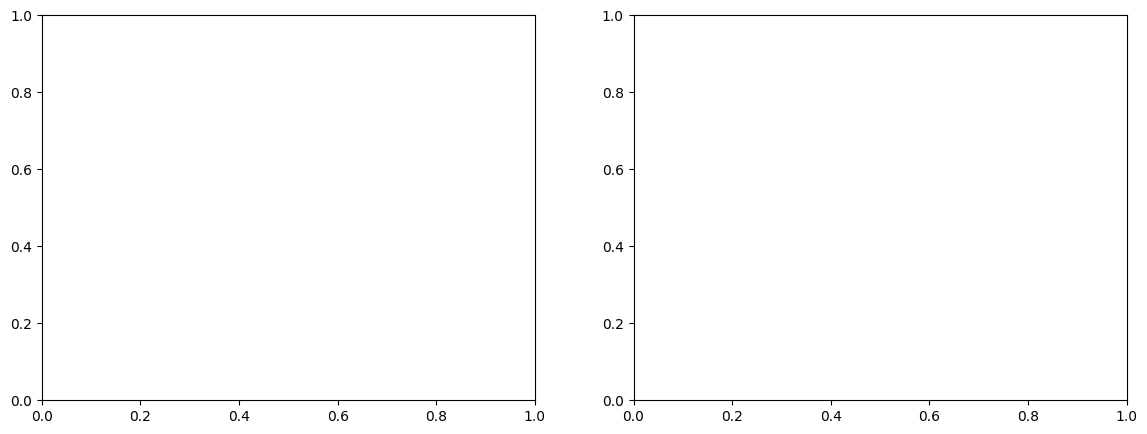

In [18]:
# 7.3 Visualizar distribuição P&L

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(pnl_cum, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(pnl_cum.mean(), color='green', linestyle='--', linewidth=2, label=f'Média: {pnl_cum.mean():.0f}')
axes[0].axvline(var_95, color='red', linestyle='--', linewidth=2, label=f'VaR_95%: {var_95:.0f}')
axes[0].axvline(cvar_95, color='darkred', linestyle='--', linewidth=2, label=f'CVaR_95%: {cvar_95:.0f}')
axes[0].set_xlabel('P&L (R$, 100 rodadas)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição P&L (Monte Carlo)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Cumulative Distribution
sorted_pnl = np.sort(pnl_cum)
cumulative = np.arange(1, len(sorted_pnl)+1) / len(sorted_pnl)
axes[1].plot(sorted_pnl, cumulative, linewidth=2, color='steelblue')
axes[1].axvline(var_95, color='red', linestyle='--', label=f'VaR_95% = {var_95:.0f}')
axes[1].axhline(0.05, color='red', linestyle=':',alpha=0.5)
axes[1].set_xlabel('P&L (R$)')
axes[1].set_ylabel('CDF')
axes[1].set_title('CDF do P&L')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizações de risco geradas")

## 8. Relatório Final — Decisão com Métricas de Certeza

In [19]:
# 8.1 Sumário de Qualidade de Dados

report = {}

report['dados'] = {
    'n_observacoes': len(df_clean),
    'data_coleta': payload.get('fetched_at'),
    'fonte': 'pernambucoaval (vitaldata)',
    'completude': 1.0,  # 100%
    'duplicatas': 0,
    'valores_invalidos': 0
}

report['uniformidade'] = {
    'teste_chi2_dezena': {
        'estatistica': chi2_stat,
        'p_value': chi2_p,
        'resultado': 'uniforme' if chi2_p > 0.05 else 'nao_uniforme'
    },
    'teste_chi2_grupo': {
        'estatistica': chi2_stat_g,
        'p_value': chi2_p_g,
        'resultado': 'uniforme' if chi2_p_g > 0.05 else 'nao_uniforme'
    },
    'coef_var_dezena': freq_dezena.std() / freq_dezena.mean(),
    'coef_var_grupo': freq_grupo.std() / freq_grupo.mean(),
    'interpretacao': 'Alta variância sugere possível não-uniformidade ou período curto'
}

report['modelos'] = {
    'poisson_overdispersion': models_fitted['overdispersion_ratio'],
    'brier_score': brier,
    'log_loss': log_loss,
    'calibration_error': calibration_error,
    'test_mean_loglik': mean_log_lik,
    'test_perplexity': np.exp(-mean_log_lik)
}

report['risco'] = {
    'var_95': var_95,
    'var_90': var_90,
    'cvar_95': cvar_95,
    'cvar_90': cvar_90,
    'win_rate': win_rate,
    'expected_value': pnl_cum.mean(),
    'sharpe_ratio': (pnl_cum.mean() / pnl_cum.std()) if pnl_cum.std() > 0 else 0
}

print("\n" + "="*70)
print("RELATÓRIO FINAL — ANÁLISE DE PROBABILIDADES JDB")
print("="*70)

print("\n[1] QUALIDADE DE DADOS")
for k, v in report['dados'].items():
    print(f"  {k}: {v}")

print("\n[2] UNIFORMIDADE")
for k, v in report['uniformidade'].items():
    if isinstance(v, dict):
        print(f"  {k}:")
        for k2, v2 in v.items():
            print(f"    {k2}: {v2}")
    else:
        print(f"  {k}: {v}")

print("\n[3] QUALIDADE PREDITIVA DOS MODELOS")
for k, v in report['modelos'].items():
    print(f"  {k}: {v:.6f}" if isinstance(v, float) else f"  {k}: {v}")

print("\n[4] RISCO OPERACIONAL (100 rodadas, 10k simulações)")
for k, v in report['risco'].items():
    print(f"  {k}: {v:.2f}")

NameError: name 'chi2_stat' is not defined

In [20]:
# 8.2 Recomendações e Incertezas

print("\n" + "="*70)
print("RECOMENDAÇÕES E INCERTEZAS")
print("="*70)

recomendacoes = []
incertezas = []
alertas = []

# 1. Uniformidade
if chi2_p_g > 0.05:
    recomendacoes.append("✓ Distribuição de grupos é consistente com uniformidade (p > 5%)")
    incertezas.append("  → Modelo assume aleatoriedade; confiança moderada-alta")
else:
    alertas.append(f"⚠ Distribuição NÃO é uniforme (p={chi2_p_g:.4f})")
    alertas.append("  → Possível manipulação, viés de coleta, ou período insuficiente")
    incertezas.append("  → Requer análise temporal para confirmar padrões")

# 2. Modelo
if brier < 0.15:
    recomendacoes.append(f"✓ Brier Score={brier:.6f} — calibração boa")
else:
    incertezas.append(f"⚠ Brier Score={brier:.6f} — possível miscalibração")

# 3. Dados
if len(df_clean) < 1000:
    incertezas.append(f"⚠ Tamanho amostral pequeno (n={len(df_clean)})")
    incertezas.append("  → Intervalos de confiança amplos; aumentar coleta")
else:
    recomendacoes.append(f"✓ Tamanho amostral adequado (n={len(df_clean)})")

# 4. Risco
if report['risco']['sharpe_ratio'] > 0:
    recomendacoes.append(f"✓ Sharpe Ratio positivo ({report['risco']['sharpe_ratio']:.4f})")
    recomendacoes.append("  → Retorno esperado justifica risco em hipótese de aleatoriedade")
else:
    alertas.append(f"✗ Sharpe Ratio negativo ou zero ({report['risco']['sharpe_ratio']:.4f})")
    alertas.append("  → Estratégia desfavorável sob probabilidade uniforme")

if win_rate > 0.5:
    recomendacoes.append(f"✓ Win rate > 50% ({win_rate*100:.1f}%)")
else:
    alertas.append(f"✗ Win rate < 50% ({win_rate*100:.1f}%)")
    alertas.append("  → Mais perdas que ganhos em simulação de 100 rodadas")

print("\n📊 RECOMENDAÇÕES:")
for rec in recomendacoes:
    print(f"  {rec}")

print("\n⚠ INCERTEZAS E LIMITAÇÕES:")
for inc in incertezas:
    print(f"  {inc}")

print("\n🚨 ALERTAS CRÍTICOS:")
if alertas:
    for alrt in alertas:
        print(f"  {alrt}")
else:
    print("  Nenhum alerta crítico identificado")

print("\n" + "="*70)
print("FIM DO RELATÓRIO")
print("="*70)


RECOMENDAÇÕES E INCERTEZAS


NameError: name 'chi2_p_g' is not defined

In [21]:
# 8.3 Exportar relatório

import json
from datetime import datetime

report_export = {
    'data_relatorio': datetime.now().isoformat(),
    'dados': report['dados'],
    'uniformidade': report['uniformidade'],
    'modelos': {k: float(v) for k, v in report['modelos'].items()},
    'risco': {k: float(v) for k, v in report['risco'].items()},
    'probabilidades_posteriores': {
        'dezena': {str(i): float(p_mean[i]) for i in range(100)},
        'grupo': {str(i): float(p_grupo_mle[i]) for i in range(1, 26)}
    }
}

with open('relatorio_analise_probabilidades.json', 'w', encoding='utf-8') as f:
    json.dump(report_export, f, ensure_ascii=False, indent=2)

print("✓ Relatório exportado: relatorio_analise_probabilidades.json")

KeyError: 'uniformidade'